拿到了新的5,6月份的数据`../data/test_data1020.csv`。
先那之前的7，8月份数据训练出来的模型用predict.py预测一下，跑出来所有指标都是0，怀疑是新的数据中的y和老的标签不一致。

In [1]:
# Make project root importable when running this notebook from the 'test' folder
import sys, os
# Add the parent directory (project root) to sys.path so 'from src...` imports work
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)
import importlib

import src.predict as _predict_mod
importlib.reload(_predict_mod)
predict = _predict_mod.predict
print('Imported predict from src.predict')

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import ast
import numpy as np


Imported predict from src.predict


In [2]:
# Load CSV
df_1020 = pd.read_csv("../data/test_data1020_34.csv")
# drop accidental index column if present
if 'Unnamed: 0' in df_1020.columns:
    df_1020 = df_1020.drop(columns=['Unnamed: 0'])
print('raw rows:', len(df_1020))
# Deduplicate by case_id (keep first occurrence)
if 'case_id' in df_1020.columns:
    before = len(df_1020)
    df_1020 = df_1020.drop_duplicates(subset=['case_id'], keep='first')
    after = len(df_1020)
    print(f'dedup by case_id: {before} -> {after} rows')
else:
    print('case_id column not found; skipping case_id dedup')


raw rows: 8639
dedup by case_id: 8639 -> 2207 rows


新数据有7323行，但是根据case_id去掉重复的数据后其实只有2718行，这么大量的重复到底是怎么造成的？我们拿着去重后的数据分析一下标签extern_id 和 linked_items的情况

In [3]:
# ---- 1) 统一把 linked_items 解析成 list ----
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        # 兼容 '["A","B"]' 或 "['A','B']" 等字符串
        try:
            v = ast.literal_eval(x)
            return v if isinstance(v, list) else [v]
        except Exception:
            return [x]
    return [x]

df_1020["linked_items"] = df_1020["linked_items"].apply(to_list)

In [4]:
# ---- 2) explode：一行一个标签（解决 list 不可哈希问题）----
# 将列表"linked_items"展开，那不就相当于直接用extern_id吗？

df_exp = df_1020.explode("linked_items").reset_index(drop=True)

# 统一成字符串，避免 123 vs "123" 的类型不一致
df_exp["linked_items"] = df_exp["linked_items"].astype(str).str.strip()

# 现在可以安全统计
total_samples = len(df_exp)
num_classes = df_exp["linked_items"].nunique()
print(f"展开后样本数: {total_samples}, 类别数: {num_classes}")

展开后样本数: 2423, 类别数: 228


In [5]:
df_exp["linked_items"].value_counts()

linked_items
48345    191
48901    149
48349     97
48327     79
48380     71
        ... 
48347      1
49011      1
51248      1
48879      1
36466      1
Name: count, Length: 228, dtype: int64

In [7]:
# ---- 3) 过滤掉样本数 <5 的类别，保证 5-fold 可用 ----
counts = df_exp["linked_items"].value_counts()
valid_items = counts[counts >= 5].index

# 不过滤
df_filtered = df_exp
df_filtered.to_csv("../output/df_1020_34.csv")

df_filtered_1020_5 = df_exp[df_exp["linked_items"].isin(valid_items)].reset_index(drop=True)
df_filtered_1020_5.to_csv("../output/df_filtered_data1020_34.csv")

print(f"原始类别数: {num_classes} -> 过滤后类别数: {df_filtered['linked_items'].nunique()}")
print(f"原始样本数(展开): {total_samples} -> 过滤后样本数: {len(df_filtered)}")




原始类别数: 228 -> 过滤后类别数: 228
原始样本数(展开): 2423 -> 过滤后样本数: 2423


In [115]:
# 参考eval.py，对没有划分train，test，eval的df_filtered_1020.csv全部视作为test进行评估

In [8]:
# 参考 eval.py：如果没有 train/test/eval 划分，直接把 df_filtered_1020 当作 test 运行评估（分批预测，计算 acc / weighted F1 / hit@k，并保存结果）
import os, glob, math
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

# try load filtered df (the one we saved earlier)
filtered_path = os.path.join('..','output','df_filtered_data1020_34.csv')

df_test = pd.read_csv(filtered_path)
print("Loaded test file:", filtered_path, "rows:", len(df_test))

# prepare true label for each row: 优先 extern_id，其次尝试 linked_items / linked_parsed 的首个元素
def pick_true_label(row):
    if 'extern_id' in row and pd.notna(row.get('extern_id')) and str(row.get('extern_id')).strip() != '':
        return str(row.get('extern_id')).strip()
    # try linked_parsed -> linked_items which may be list-string
    if 'linked_parsed' in row and isinstance(row.get('linked_parsed'), str):
        # in some cases linked_parsed saved as "['123']" string, try ast
        try:
            import ast
            v = ast.literal_eval(row.get('linked_parsed'))
            if isinstance(v, (list,tuple)) and len(v)>0:
                return str(v[0])
        except Exception:
            pass
    for col in ('linked_parsed','linked_items'):
        val = row.get(col)
        if isinstance(val, list) and val:
            return str(val[0])
        if pd.notna(val) and isinstance(val, str):
            # try parse simple list-string like "['1','2']" or "[123]"
            try:
                import ast
                v = ast.literal_eval(val)
                if isinstance(v, (list,tuple)) and v:
                    return str(v[0])
            except Exception:
                # fallback: use token extraction
                import re
                m = re.findall(r"[0-9A-Za-z_]+", val)
                if m:
                    return str(m[0])
    return ''  # unknown / empty

df_test['true_label'] = df_test.apply(pick_true_label, axis=1)
print("Samples with non-empty true_label:", (df_test['true_label'] != '').sum(), "/", len(df_test))

# choose features to pass to predict; predict() in this repo expects DataFrame with case_title/performed_work (it can accept full rows)
X_cols = []
for c in ('case_title','performed_work'):
    if c in df_test.columns:
        X_cols.append(c)
# if no known text columns, pass full frame
if not X_cols:
    X_df = df_test.copy()
else:
    X_df = df_test[X_cols].copy()

# select model path (prefer model_best.joblib)
model_best = os.path.join('..','output','model_best.joblib')
model_path = None
if os.path.exists(model_best):
    model_path = model_best
else:
    cand = sorted(glob.glob(os.path.join('..','output','model_*.joblib')))
    if cand:
        model_path = cand[0]
if model_path is None:
    raise FileNotFoundError("未找到模型文件 (../output/model_best.joblib 或 ../output/model_*.joblib)")

print("Using model:", model_path)

# batch predict to avoid一次性内存峰值
batch_size = 256
n = len(X_df)
results = []
for i in tqdm(range(0, n, batch_size), desc="Predict batches"):
    batch = X_df.iloc[i: i+batch_size]
    try:
        res_batch = predict(batch, model_path=model_path, top_k=10)
    except TypeError:
        # some predict implementations accept (X, top_k=...) and model loaded internally; try without model_path
        res_batch = predict(batch, top_k=10)
    # ensure list-like
    if isinstance(res_batch, dict):
        # single sample dict? wrap
        res_batch = [res_batch]
    results.extend(res_batch)

# normalize results and build dataframe of predictions
rows = []
for idx, r in enumerate(results):
    row_idx = idx  # corresponds to df_test.iloc[idx]
    # handle different result formats
    if isinstance(r, dict):
        preds = r.get('preds') or r.get('labels') or []
        scores = r.get('scores') or r.get('probs') or []
    elif isinstance(r, (list,tuple)) and len(r)>=1:
        preds = r[0] if isinstance(r[0], list) else r
        scores = r[1] if len(r)>1 else []
    else:
        preds = []
        scores = []
    # coerce preds->list of str
    preds = [str(x) for x in (preds or [])]
    scores = [float(x) for x in (scores or [])[:len(preds)]]
    true = str(df_test.iloc[row_idx]['true_label']) if pd.notna(df_test.iloc[row_idx].get('true_label')) else ''
    top1 = preds[0] if preds else ''
    hit1 = int(true != '' and top1 == true)
    hit3 = int(true != '' and true in preds[:3])
    hit5 = int(true != '' and true in preds[:5])
    hit10 = int(true != '' and true in preds[:10])
    rows.append({
        'index': df_test.index[row_idx],
        'extern_id': df_test.iloc[row_idx].get('extern_id') if 'extern_id' in df_test.columns else None,
        'case_id': df_test.iloc[row_idx].get('case_id') if 'case_id' in df_test.columns else None,
        'true_label': true,
        'pred_top1': top1,
        'preds_top10': "|".join(preds),
        'scores_top10': "|".join(f"{s:.4f}" for s in scores),
        'hit@1': hit1,
        'hit@3': hit3,
        'hit@5': hit5,
        'hit@10': hit10
    })

pred_df = pd.DataFrame(rows)

# metrics (only on samples with non-empty true_label)
valid = pred_df[pred_df['true_label'].astype(str) != '']
y_true = valid['true_label'].tolist()
y_pred_top1 = valid['pred_top1'].tolist()

acc = accuracy_score(y_true, y_pred_top1) if len(y_true)>0 else float('nan')
try:
    f1_w = f1_score(y_true, y_pred_top1, average='weighted') if len(y_true)>0 else float('nan')
except Exception as e:
    # if f1 fails (e.g. single class), fallback to 0 or nan
    print("计算 weighted F1 失败：", e)
    f1_w = float('nan')

hit1 = pred_df['hit@1'].mean() if len(pred_df)>0 else float('nan')
hit3 = pred_df['hit@3'].mean() if len(pred_df)>0 else float('nan')
hit5 = pred_df['hit@5'].mean() if len(pred_df)>0 else float('nan')
hit10 = pred_df['hit@10'].mean() if len(pred_df)>0 else float('nan')

print(f"\nMetrics on df_filtered test (n={len(pred_df)} samples, valid true labels={len(valid)}):")
print(f"  Accuracy (top1): {acc:.6f}")
print(f"  Weighted F1 (top1): {f1_w:.6f}")
print(f"  hit@1: {hit1:.6f}, hit@3: {hit3:.6f}, hit@5: {hit5:.6f}, hit@10: {hit10:.6f}")

# 保存预测结果
os.makedirs(os.path.join('..','output'), exist_ok=True)
out_path = os.path.join('..','output','predictions_df_filtered_1020.csv')
pred_df.to_csv(out_path, index=False, encoding='utf-8-sig')
print("Predictions saved to:", out_path)
# ...existing code...

Loaded test file: ..\output\df_filtered_data1020_34.csv rows: 2207
Samples with non-empty true_label: 2207 / 2207
Using model: ..\output\model_best.joblib


Predict batches: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]



Metrics on df_filtered test (n=2207 samples, valid true labels=2207):
  Accuracy (top1): 0.016765
  Weighted F1 (top1): 0.023238
  hit@1: 0.016765, hit@3: 0.038514, hit@5: 0.038514, hit@10: 0.038514
Predictions saved to: ..\output\predictions_df_filtered_1020.csv


In [15]:
df_filtered_1017 = pd.read_csv("../output/df_filtered_1020_5.csv")
df_filtered_1020 = pd.read_csv("../output/df_filtered_1020_34.csv")

In [16]:
len(df_filtered_1017["linked_items"].unique()),len(df_filtered_1020["linked_items"].unique())

(99, 98)

In [17]:
df_filtered_1017["linked_items"].unique()

array([50174, 50308, 50019, 49661, 49691, 49812, 50862, 49747, 50380,
       50097, 49686, 50769, 50675, 50910, 50230, 49971, 28104, 50883,
       50385, 50349, 50822, 50391, 50710, 50785, 49690, 50585, 50584,
       49810, 50664, 50264, 49592, 50307, 49688, 49721, 50142, 50774,
       50879, 50682, 50172, 49642, 49948, 50280, 49545, 49669, 49980,
       49939, 50467, 50723, 50148, 49544, 50265, 49856, 49811, 49782,
       49626, 49582, 49813, 50765, 50382, 50316, 49938, 49937, 50907,
       50666, 50401, 50358, 50776, 49970, 49684, 49729, 49828, 49854,
       50859, 50356, 48742, 50413, 50616, 49105, 50339, 50634, 49692,
       39899, 50159, 50116, 49716, 19116, 50683, 50620, 50818, 50712,
       50417, 49658, 50150, 50309, 50782, 50621, 50892, 49965, 50141])

In [18]:
df_filtered_1020["linked_items"].unique()

array([47899, 48349, 48684, 44742, 48474, 49340, 49178, 48734, 40970,
       48521, 48327, 48742, 48901, 50385, 48813, 48137, 49136, 49041,
       48219, 48058, 48602, 47898, 48304, 48313, 48380, 48224, 48376,
       49346, 48717, 50339, 49105, 48170, 49049, 48268, 48303, 49177,
       49117, 48816, 48926, 45096, 48345, 48618, 48874, 48451, 48060,
       49390, 48524, 49337, 49077, 32030, 49076, 47975, 48763, 49082,
       48472, 48894, 48964, 49214, 40309, 48563, 48932, 48183, 48725,
       48771, 48715, 48876, 48945, 48438, 47917, 48804, 49142, 49115,
       47952, 51636, 48302, 49336, 48714, 48528, 49147, 48809, 48479,
       38988, 48520, 48764, 49396, 47902, 48423, 51915, 48355, 34303,
       49215, 49256, 48408, 49307, 48897, 49004, 49317, 48488])

In [19]:
# 统一为字符串再取集合（防止类型差异）
set_1017 = set(df_filtered_1017["linked_items"].astype(str).unique())
set_1020 = set(df_filtered_1020["linked_items"].astype(str).unique())
print(set_1017)
print(set_1020)

common = sorted(set_1017 & set_1020)
print(f"交集标签数: {len(common)}，示例前30个: {common[:30]}")

# 过滤出新数据中属于交集的行
df_common_rows = df_filtered_1020[df_filtered_1020["linked_items"].astype(str).isin(common)].copy()
print("df_filtered_1020 中属于交集的行数：", len(df_common_rows))



{'50142', '50097', '49810', '49970', '50019', '50712', '39899', '50822', '49688', '50349', '49938', '50309', '50782', '49812', '50307', '50664', '50769', '50265', '49854', '49828', '49661', '50683', '50148', '49856', '50417', '49965', '50172', '50380', '50280', '49686', '28104', '49692', '50818', '50666', '50391', '49811', '49684', '50879', '49729', '49939', '49544', '50358', '50862', '49582', '50859', '49669', '50620', '49813', '50174', '50585', '49545', '49105', '49971', '49626', '50159', '49716', '50401', '50316', '49642', '50723', '50634', '50230', '50883', '50413', '50621', '50150', '50765', '49721', '50774', '49937', '50785', '49948', '50385', '49691', '50892', '50141', '50116', '50616', '49658', '50682', '50264', '49690', '49980', '50308', '49747', '49592', '50356', '48742', '50467', '50710', '49782', '50382', '19116', '50339', '50910', '50776', '50907', '50584', '50675'}
{'49390', '48472', '49041', '32030', '48528', '48524', '49256', '51636', '48058', '48345', '49215', '49214',

两个数据集只有6个样本共5种标签有交集且这5个标签对应的样本量都小于5，以至于一开始被筛掉了，我们重新挑出来这5个标签的6个数据，重新调用predict看看效果

In [21]:
# 两个数据集只有6个样本共5种标签有交集且这5个标签对应的样本量都小于5，以至于一开始被筛掉了，我们重新挑出来这5个标签的6个数据，重新调用predict看看效果
import os, glob, ast, re
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

a = df_filtered_1017
b = df_filtered_1020

# 统一把 linked_items 解析成 list（若已经是 list 则保持）
def parse_linked(x):
    if pd.isna(x): 
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        # 尝试 ast 解析 '[...]'，否则按非字母数字下划线分割取 tokens
        try:
            v = ast.literal_eval(x)
            if isinstance(v, (list,tuple)):
                return [str(i) for i in v]
            return [str(v)]
        except Exception:
            tokens = re.findall(r"[0-9A-Za-z_]+", x)
            return [t for t in tokens] if tokens else [x.strip()]
    return [str(x)]

a['linked_items_parsed'] = a['linked_items'].apply(parse_linked)
b['linked_items_parsed'] = b['linked_items'].apply(parse_linked)

set_a = set([str(x) for sub in a['linked_items_parsed'] for x in sub])
set_b = set([str(x) for sub in b['linked_items_parsed'] for x in sub])
common = sorted(list(set_a & set_b))
print("交集标签（count）:", len(common), common)

# 过滤出新数据中属于交集的行
def has_common(row):
    return any(str(x) in common for x in row.get('linked_items_parsed', []))

df_common_rows = b[b.apply(has_common, axis=1)].copy()
df_common_rows.to_csv("../output/common_34_56.csv")


交集标签（count）: 4 ['48742', '49105', '50339', '50385']


In [122]:
df_filtered_1020["linked_items"].value_counts()

linked_items
50174    261
50822    251
50385    145
50159     77
50785     77
        ... 
3940       1
52012      1
25744      1
50028      1
36013      1
Name: count, Length: 288, dtype: int64

In [123]:
# 如果 linked_items 是列表，要先展开
import pandas as pd
import numpy as np

# 若 linked_items 是 list 或 "[...]" 字符串，先转
def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    try:
        return eval(x)
    except:
        return [x]

df_filtered_1020["linked_items"] = df_filtered_1020["linked_items"].apply(to_list)

# 展开一对多
df_exploded = df_filtered_1020.explode("linked_items")

# 统计每个 item 对应的 case_id 数
item_case_stats = (
    df_exploded.groupby("linked_items")["case_id"]
    .nunique()
    .reset_index(name="case_count")
    .sort_values("case_count", ascending=True)
)

print(item_case_stats.head(10))


    linked_items  case_count
16         24997           1
17         25744           1
19         31336           1
22         33697           1
23         34303           1
24         35595           1
25         35596           1
26         36013           1
27         36359           1
28         37666           1


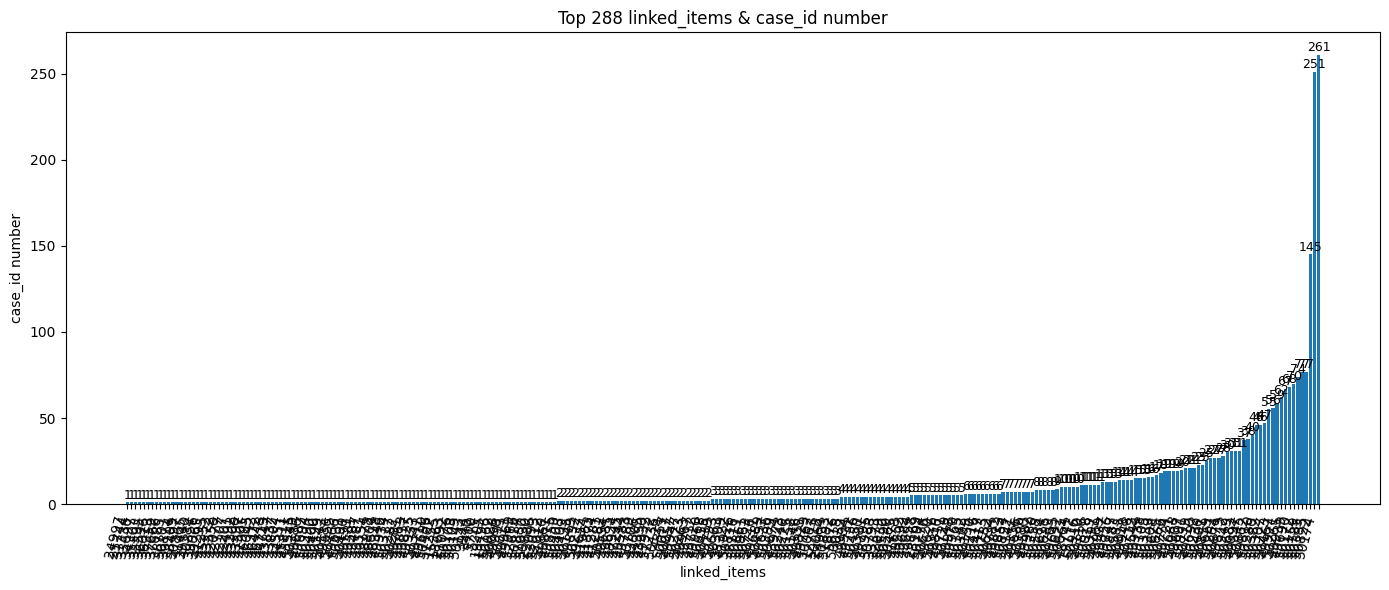

In [128]:
# 画出item_case_stats的分布柱状图，表上每个柱子有对应几个数据
import matplotlib.pyplot as plt
import pandas as pd

top_n = len(df_filtered_1020["linked_items"].value_counts())
data = item_case_stats.head(top_n)

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(data)), data["case_count"], tick_label=data["linked_items"])

# 在柱子顶部标注数值
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # 数值显示在柱顶略高处
        str(int(height)),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.xticks(rotation=75, ha="right")
plt.title(f"Top {top_n} linked_items & case_id number")
plt.xlabel("linked_items")
plt.ylabel("case_id number")
plt.tight_layout()
plt.show()


在5，6月份的数据上重新训练并预测，看看效果

```log
PS C:\Users\ux018677\Downloads\BMW-item> python .\src\eval.py
[All train]
acc=0.950 | f1_macro=0.923 | hit@1=0.950 | hit@3=0.994 | hit@5=0.996 | hit@10=0.998
[All val]
acc=0.893 | f1_macro=0.892 | hit@1=0.893 | hit@3=0.966 | hit@5=0.974 | hit@10=0.984
[All test]
acc=0.891 | f1_macro=0.891 | hit@1=0.891 | hit@3=0.964 | hit@5=0.972 | hit@10=0.984
```